## Sample Simulation of Traditional U-net for DRIVE database
Paper reference: Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional networks for biomedical image segmentation (arXiv:1505.04597). arXiv. https://doi.org/10.48550/arXiv.1505.04597

In [1]:
# standard imports
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import torchvision.transforms as transforms

from PIL import Image
import io

In [2]:
# DATASET directories
# DRIVE
data_dir = "../data/Retinal_Vessel_Segmentation_Datasets/DRIVE/"


In [3]:
class RetinalDataset(Dataset):
    def __init__(self, image_paths, mask_paths, use_clahe=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.use_clahe = use_clahe

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise FileNotFoundError(f"Could not load image at {self.image_paths[idx]}")

        image = cv2.resize(image, (512, 512))

        if self.use_clahe:
            image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe = cv2.createCLAHE(clipLimit=5.0)
            image = clahe.apply(image_bw)
            image = np.clip(image, 0, 255).astype(np.uint8)
            image = np.expand_dims(image, axis=0)  # shape: (1, H, W)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = image / 255.0
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # shape: (3, H, W)

        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Could not load mask at {self.mask_paths[idx]}")
        mask = cv2.resize(mask, (512, 512))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=0).astype(np.float32)

        if self.use_clahe:
            image = image / 255.0
            image = image.astype(np.float32)

        return torch.tensor(image), torch.tensor(mask)


In [4]:
# define paths to training and test images/masks
train_img_paths = sorted(glob(os.path.join(data_dir, "training/images/*.png")))   # jpg kapag stare
train_mask_paths = sorted(glob(os.path.join(data_dir, "training/1st_manual/*.png")))

test_img_paths = sorted(glob(os.path.join(data_dir, "test/images/*.png")))
test_mask_paths = sorted(glob(os.path.join(data_dir, "test/1st_manual/*.png")))

In [5]:
# create the datasets
train_dataset = RetinalDataset(train_img_paths, train_mask_paths)
test_dataset = RetinalDataset(test_img_paths, test_mask_paths)

# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

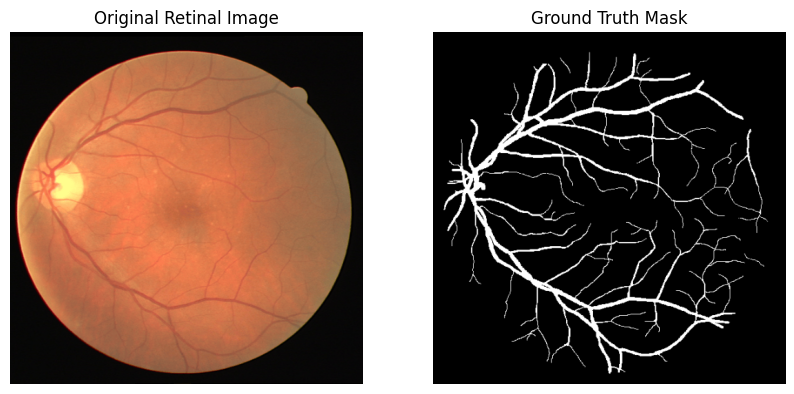

In [6]:
# load the original image directly using OpenCV from the path
original_img_path = train_img_paths[0]
original_img = cv2.imread(original_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (512, 512))  # resize

# load the mask
mask = cv2.imread(train_mask_paths[0], cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (512, 512))  # size match

# plot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Retinal Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.show()

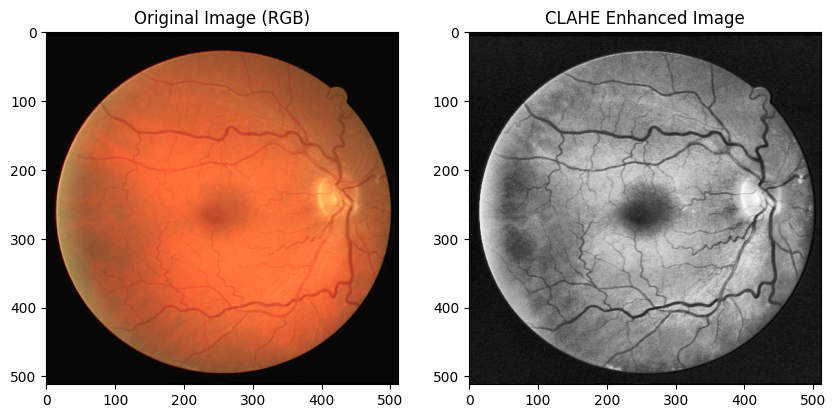

In [7]:
dataset_no_clahe = RetinalDataset(train_img_paths, train_mask_paths, use_clahe=False)
dataset_clahe = RetinalDataset(train_img_paths, train_mask_paths, use_clahe=True)

img_noclahe, _ = dataset_no_clahe[1]
img_clahe, _ = dataset_clahe[1]

plt.figure(figsize=(10, 5))

# Original RGB image
plt.subplot(1, 2, 1)
plt.imshow(img_noclahe.permute(1, 2, 0).numpy())  # (C, H, W) → (H, W, C)
plt.title("Original Image (RGB)")

# CLAHE grayscale image
plt.subplot(1, 2, 2)
plt.imshow(img_clahe.squeeze(0).numpy(), cmap='gray')
plt.title("CLAHE Enhanced Image")

plt.show()


In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = EncoderBlock(1, 64)
        self.e2 = EncoderBlock(64, 128)
        self.e3 = EncoderBlock(128, 256)
        self.e4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.d1 = DecoderBlock(1024, 512)
        self.d2 = DecoderBlock(512, 256)
        self.d3 = DecoderBlock(256, 128)
        self.d4 = DecoderBlock(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        b = self.bottleneck(p4)

        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        return self.final(d4)

In [9]:
from torch import optim

# move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# loss function for binary segmentation
criterion = nn.BCEWithLogitsLoss()  # Assumes raw logits are returned (not passed through sigmoid)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, masks)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

In [11]:
epochs = 100
for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}")

Epoch 1/100, Loss: 0.6401
Epoch 2/100, Loss: 0.5042
Epoch 3/100, Loss: 0.4251
Epoch 4/100, Loss: 0.3826
Epoch 5/100, Loss: 0.3617
Epoch 6/100, Loss: 0.3497
Epoch 7/100, Loss: 0.3414
Epoch 8/100, Loss: 0.3323
Epoch 9/100, Loss: 0.3247
Epoch 10/100, Loss: 0.3192
Epoch 11/100, Loss: 0.3138
Epoch 12/100, Loss: 0.3069
Epoch 13/100, Loss: 0.3007
Epoch 14/100, Loss: 0.2945
Epoch 15/100, Loss: 0.2896
Epoch 16/100, Loss: 0.2848
Epoch 17/100, Loss: 0.2796
Epoch 18/100, Loss: 0.2747
Epoch 19/100, Loss: 0.2696
Epoch 20/100, Loss: 0.2652
Epoch 21/100, Loss: 0.2613
Epoch 22/100, Loss: 0.2579
Epoch 23/100, Loss: 0.2533
Epoch 24/100, Loss: 0.2495
Epoch 25/100, Loss: 0.2448
Epoch 26/100, Loss: 0.2406
Epoch 27/100, Loss: 0.2368
Epoch 28/100, Loss: 0.2334
Epoch 29/100, Loss: 0.2303
Epoch 30/100, Loss: 0.2265
Epoch 31/100, Loss: 0.2234
Epoch 32/100, Loss: 0.2197
Epoch 33/100, Loss: 0.2159
Epoch 34/100, Loss: 0.2133
Epoch 35/100, Loss: 0.2094
Epoch 36/100, Loss: 0.2055
Epoch 37/100, Loss: 0.2028
Epoch 38/1

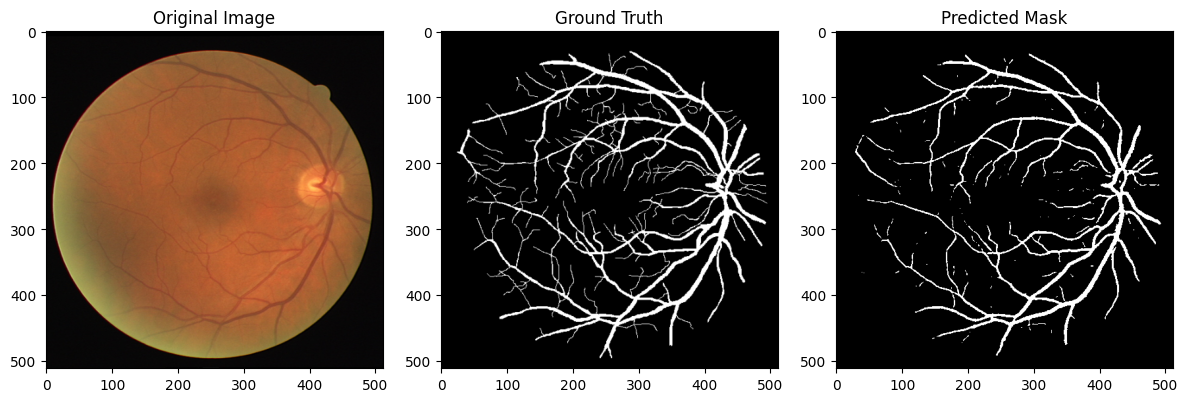

In [12]:
# evaluation mode
model.eval()

# pick one sample index
idx = 5

# load model-ready tensors from dataset
image_tensor, true_mask = test_dataset[idx]
image_tensor = image_tensor.unsqueeze(0).to(device)  # add batch dimension

# load the original (non-CLAHE) image from disk
original_img_path = test_img_paths[idx]
original_img = cv2.imread(original_img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (512, 512))  # ensure same shape

# predict
with torch.no_grad():
    output = model(image_tensor)
    pred_mask = torch.sigmoid(output[0, 0])  # convert to probability map
    pred_mask = pred_mask.cpu().numpy()

# threshold the mask
binary_mask = (pred_mask > 0.5).astype(np.uint8)

# ground truth mask
true_mask_np = true_mask[0].cpu().numpy()

# plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(original_img); plt.title("Original Image")
plt.subplot(1, 3, 2); plt.imshow(true_mask_np, cmap="gray"); plt.title("Ground Truth")
plt.subplot(1, 3, 3); plt.imshow(binary_mask, cmap="gray"); plt.title("Predicted Mask")
plt.tight_layout()
plt.show()

In [13]:
def visualize_predictions(model, dataset, img_paths, num_samples=3):
    model.eval()
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        image, true_mask = dataset[i]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            pred = torch.sigmoid(output[0, 0])
            pred = pred.cpu().numpy()
            binary_pred = (pred > 0.5).astype(np.uint8)

        # load the original (non-CLAHE) image from disk
        raw_img = cv2.imread(img_paths[i])
        raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
        raw_img = cv2.resize(raw_img, (512, 512))  # match preprocessing size

        true_mask_np = true_mask[0].cpu().numpy()

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(raw_img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask_np, cmap="gray")
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(binary_pred, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

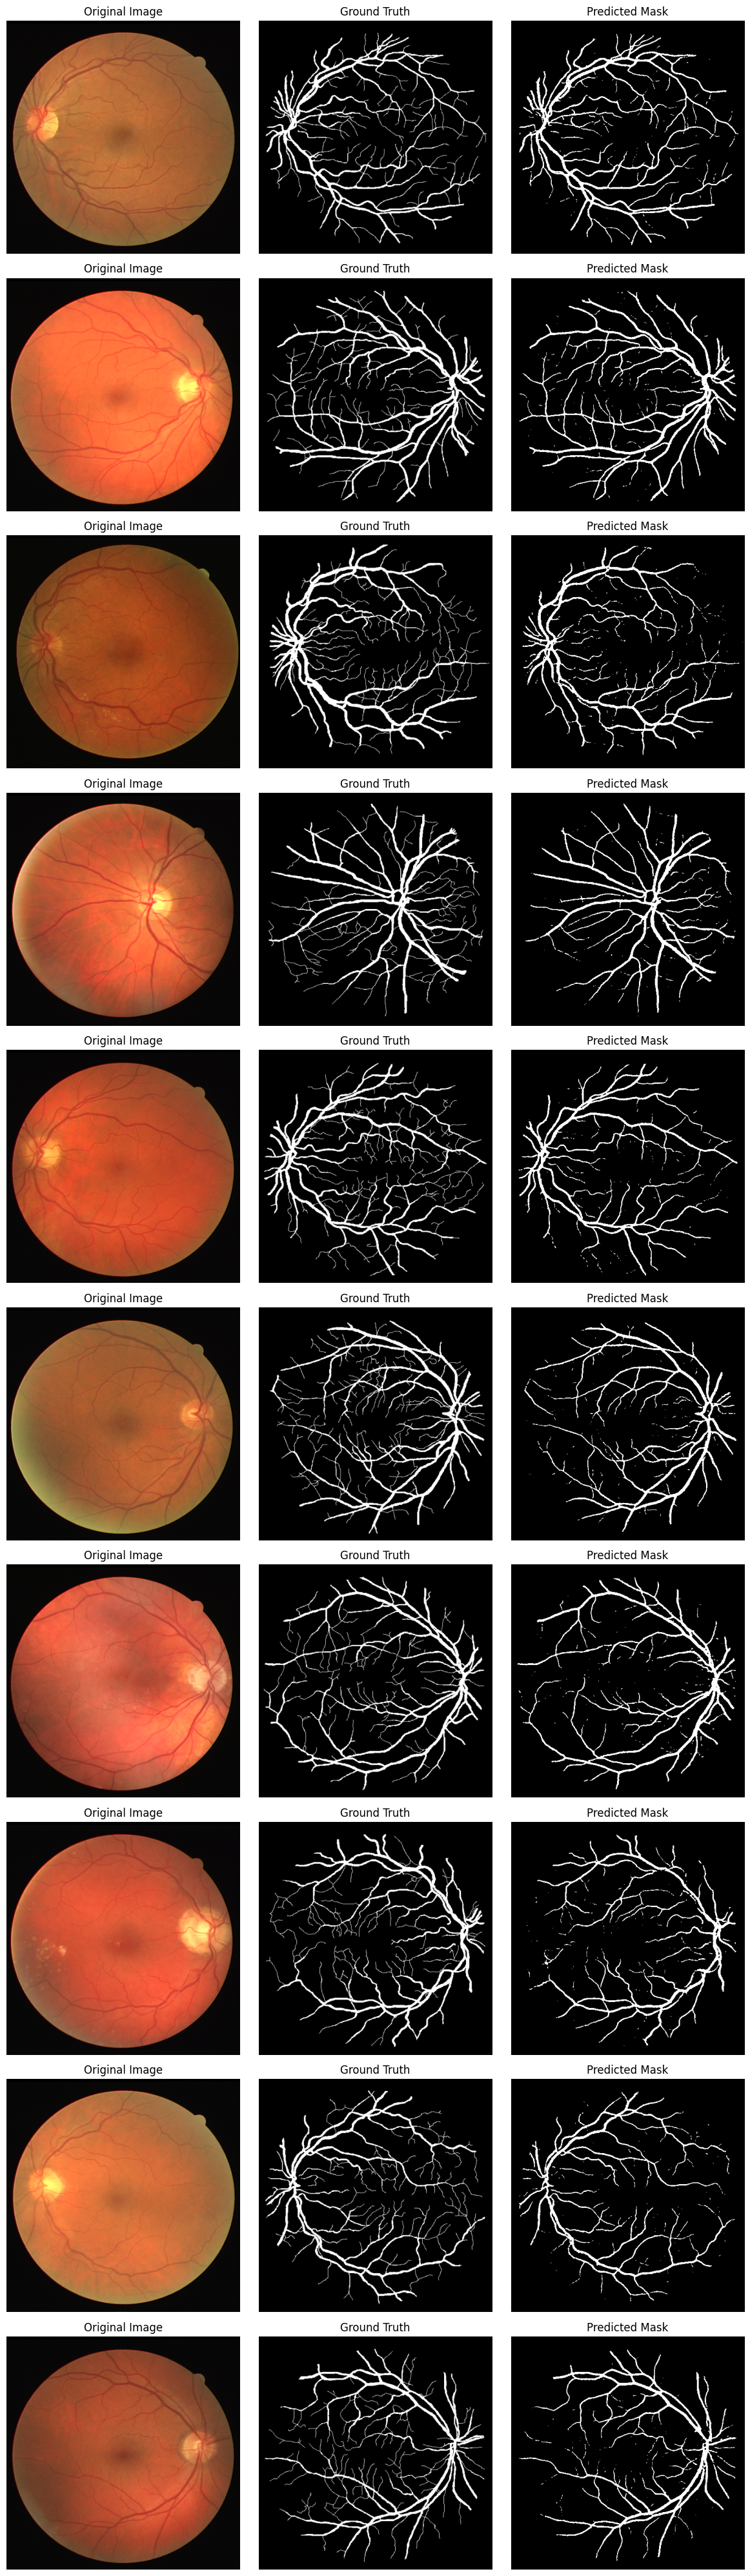

In [14]:
visualize_predictions(model, test_dataset, test_img_paths, num_samples=10)

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch.nn.functional as F

In [17]:
def dice_score(pred, target):
    smooth = 1e-5
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target):
    smooth = 1e-5
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def accuracy_score(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    return (pred == target).sum() / len(pred)

def sensitivity_score(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    TP = (pred * target).sum()
    FN = ((1 - pred) * target).sum()
    return TP / (TP + FN + 1e-5)

def specificity_score(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    TN = ((1 - pred) * (1 - target)).sum()
    FP = (pred * (1 - target)).sum()
    return TN / (TN + FP + 1e-5)

In [18]:
model.eval()
dice_total, iou_total, acc_total, sen_total, spec_total = 0, 0, 0, 0, 0
n = len(test_dataset)

with torch.no_grad():
    for i in range(n):
        image, mask = test_dataset[i]
        image = image.unsqueeze(0).to(device)
        mask = mask.squeeze().numpy()

        output = model(image)
        output = torch.sigmoid(output).cpu().squeeze().numpy()
        pred = (output > 0.5).astype(np.uint8)

        dice_total += dice_score(pred, mask)
        iou_total += iou_score(pred, mask)
        acc_total += accuracy_score(pred, mask)
        sen_total += sensitivity_score(pred, mask)
        spec_total += specificity_score(pred, mask)

# Average metrics
print("Test Set Evaluation Metrics:")
print(f"Dice Coefficient: {dice_total / n:.4f}")
print(f"IoU Score:        {iou_total / n:.4f}")
print(f"Accuracy:         {acc_total / n:.4f}")
print(f"Sensitivity:      {sen_total / n:.4f}")
print(f"Specificity:      {spec_total / n:.4f}")

Test Set Evaluation Metrics:
Dice Coefficient: 0.7707
IoU Score:        0.6275
Accuracy:         0.9206
Sensitivity:      0.7281
Specificity:      0.9850


In [35]:
## upload fundus image
#uploaded_image = files.upload()

In [ ]:
# upload ground truth
#uploaded_groundtruth = files.upload()

In [ ]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

# 1) Create & display two uploaders
uploader_img = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)
uploader_gt = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Ground-Truth'
)
display(widgets.HTML("<b>Original Fundus Image:</b>"), uploader_img)
display(widgets.HTML("<b>Ground-Truth Mask:</b>"), uploader_gt)

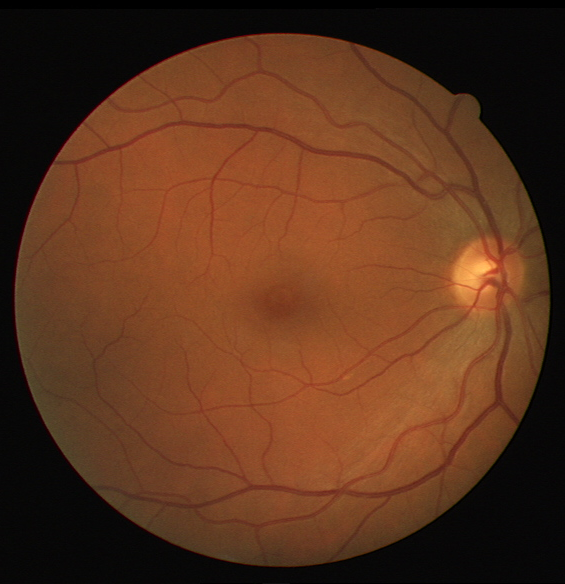

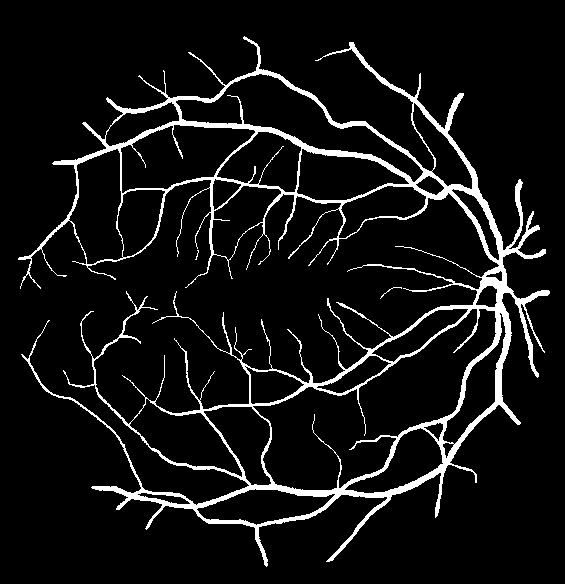

In [39]:
import io
from PIL import Image
from IPython.display import display

# 2) Wait for user to upload, then run:
if uploader_img.value and uploader_gt.value:
    # --- Extract uploaded_image as PIL ---
    val = uploader_img.value
    info = next(iter(val.values())) if isinstance(val, dict) else val[0]
    uploaded_image = Image.open(io.BytesIO(info['content']))
    
    # --- Extract uploaded_groundtruth as PIL ---
    val = uploader_gt.value
    info = next(iter(val.values())) if isinstance(val, dict) else val[0]
    uploaded_groundtruth = Image.open(io.BytesIO(info['content']))
    
    # verify
    display(uploaded_image)
    display(uploaded_groundtruth)
else:
    print("⚠️ Please upload both files in the upload widgets above.")


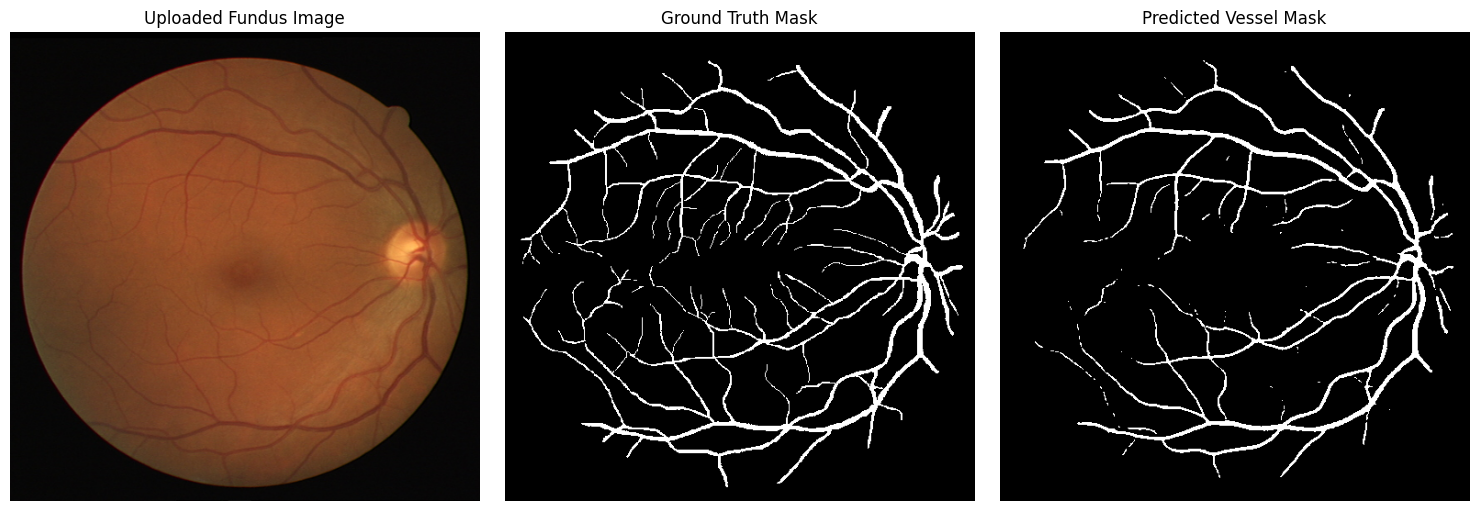

Dice Coefficient: 0.7588
IoU Score:        0.6114
Accuracy:         0.9672
Sensitivity:      0.6839
Specificity:      0.9903


In [40]:
# load uploaded image
#img_filename = next(iter(uploaded_image))
#image = Image.open(io.BytesIO(uploaded_image[img_filename])).convert('RGB')

# load uploaded ground truth mask
#gt_filename = next(iter(uploaded_groundtruth))
#gt_mask = Image.open(io.BytesIO(uploaded_groundtruth[gt_filename])).convert('L')


# load uploaded image
image = uploaded_image.convert('RGB')

# load uploaded ground truth mask
gt_mask = uploaded_groundtruth.convert('L')

# preprocess image
image_np = np.array(image)
image_resized = cv2.resize(image_np, (512, 512))

# apply CLAHE (optional)
lab = cv2.cvtColor(image_resized, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl = clahe.apply(l)
merged = cv2.merge((cl, a, b))
clahe_image = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

    # transform to tensor
# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])
# input_tensor = transform(clahe_image).unsqueeze(0).to(device)

gray = cv2.cvtColor(clahe_image, cv2.COLOR_RGB2GRAY)
input_tensor = (
    torch.from_numpy(gray)
         .unsqueeze(0)    # channel dim → [1, H, W]
         .unsqueeze(0)    # batch dim   → [1, 1, H, W]
         .float() / 255.0
).to(device)

# predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_mask = torch.sigmoid(output[0, 0]).cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

# process ground truth mask
gt_np = np.array(gt_mask)
gt_resized = cv2.resize(gt_np, (512, 512), interpolation=cv2.INTER_NEAREST)
gt_binary = (gt_resized > 127).astype(np.uint8)  # Ensure binary

# compute evaluation metrics
intersection = np.logical_and(binary_mask, gt_binary).sum()
union = np.logical_or(binary_mask, gt_binary).sum()
dice = 2 * intersection / (binary_mask.sum() + gt_binary.sum() + 1e-8)
iou = intersection / (union + 1e-8)
accuracy = (binary_mask == gt_binary).sum() / gt_binary.size
sensitivity = intersection / (gt_binary.sum() + 1e-8)
specificity = ((1 - binary_mask) * (1 - gt_binary)).sum() / ((1 - gt_binary).sum() + 1e-8)

# display
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_resized)
plt.title("Uploaded Fundus Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_binary, cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted Vessel Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

# print metrics
print(f"Dice Coefficient: {dice:.4f}")
print(f"IoU Score:        {iou:.4f}")
print(f"Accuracy:         {accuracy:.4f}")
print(f"Sensitivity:      {sensitivity:.4f}")
print(f"Specificity:      {specificity:.4f}")